In [2]:
import numpy as np
import pandas as pd
import math
import time
from scipy.io import wavfile
from skimage import util
from scipy import signal
from scipy import stats

#from sklearn.preprocessing import StandardScaler
#from sklearn.model_selection import KFold, train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV

#from sklearn.cluster import KMeans
#from sklearn.metrics.cluster import silhouette_score

#visualizing results
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
#import yellowbrick as yb

In [3]:
file_path_wav = 'C:/Users/Schindler/Documents/Schindler_Lab/Data/USVs/CPA_pair_exp/18.12.07_CPA_pair_3x/535.wav'

In [4]:
samp_freq, sig_data = wavfile.read(file_path_wav)

In [5]:
sig_data = sig_data[0:150000000]
sig_data.shape
samp_freq

250000

In [6]:
def create_slice_from_wav(file_path, slice_len, step_size):
    """Creates small slices from wav file. Slice_len (use sampling frequency to convert to ms). 
    Step_size is amount of overlap between each slice."""
    
    #read in wav file
    samp_freq, sig_data = wavfile.read(file_path)
    print('Sampling frequency: ' + str(samp_freq))
    
    sig_data = sig_data[0:150000000]
    
    #determine number of samples and length
    n_samples = sig_data.shape[0]
    print('Number of samples: ' + str(n_samples))
    sig_len = n_samples/samp_freq
    print('Length: ' + str(sig_len) + ' sec')
    
    #create slices 
    M = slice_len
    steps = int(M*step_size)
    slices = util.view_as_windows(sig_data, window_shape=(M,), step=steps)
    print(f'Audio shape: {sig_data.shape}, Sliced audio shape: {slices.shape}')
    
    return samp_freq, sig_data, slices, steps

In [7]:
def plot_spec(Sx, times, steps, time_stamp):
    """Plots a spectrogram from a slice"""
    
    f, ax = plt.subplots()
    plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(Sx), cmap = 'cubehelix')
    ax.ticklabel_format(useOffset=False)
    plt.ylabel('Frequency [kHz]')
    plt.xlabel('Time [msec]')
    plt.show()
    
    return plt

In [8]:
def multi_plot(image_df, time_stamp_list, x, y):
    """Plots spectrograms from a list of time_stamps"""
    for time_stamp in time_stamp_list[x:y]:
        plt.figure(figsize = (2,5))
        plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(image_df[time_stamp]), cmap = 'cubehelix')
        plt.show()

In [9]:
def find_features(data):
    """Finds spectral flatness and power sum for each time stamp in a df."""
    
    start = time.time()
    
    feature_df = pd.DataFrame(index = data.index, columns = ['time_stamp', 'spec_flat', 'power_sum'])
    
    for time_stamp in data.index:
        #spectral flattness
        feature_df.loc[time_stamp]['spec_flat'] = (stats.gmean(data.loc[time_stamp])) / (data.loc[time_stamp].mean())
        #power sum
        feature_df.loc[time_stamp]['power_sum'] = data.loc[time_stamp].sum()
        #time stamp
        feature_df.loc[time_stamp]['time_stamp'] = time_stamp
        
    end = time.time()
    print(end - start)

    return feature_df

In [10]:
def make_power_sum_df(data):
    power_sum_df = pd.DataFrame(index = data.index, columns = ['time_stamp', 'power_sum'])
    for time_stamp in data.index:
        power_sum_df.loc[time_stamp]['power_sum'] = data.loc[time_stamp].sum()
        power_sum_df.loc[time_stamp]['time_stamp'] = time_stamp
    return power_sum_df

In [11]:
def make_spec_flat_df(data):
    spec_flat_df = pd.DataFrame(index = data.index, columns = ['time_stamp', 'spec_flat'])
    for time_stamp in data.index:
        x = data.loc[time_stamp]
        spec_flat_df.loc[time_stamp]['spec_flat'] = (stats.gmean(x)) / (x.mean())
        spec_flat_df.loc[time_stamp]['time_stamp'] = time_stamp
    return spec_flat_df

Create slices from wav file

In [12]:
samp_freq, sig_data, slices, steps = create_slice_from_wav(file_path_wav, 6250, 0.9)

Sampling frequency: 250000
Number of samples: 150000000
Length: 600.0 sec
Audio shape: (150000000,), Sliced audio shape: (26666, 6250)


Create spectrogram from each slice (option to plot)

In [15]:
start = time.time()
spec_window = 128
NFFT = 512
samp_freq_kHz = samp_freq/1000
i = 0
spec_slices = {}
spec_slices_ravel = {}
    
for i in range(slices.shape[0]): 
    #spectrogram
    freqs_spec, times, Sx = signal.spectrogram(slices[i,:], fs=samp_freq, nperseg = spec_window, nfft = NFFT)
    
    time_stamp = i*steps / samp_freq_kHz
    
    #plot spectrogram
    #plt_spec = plot_spec(Sx, times, steps, time_stamp)
    
    #store as dic
    spec_slices[time_stamp] = Sx
    spec_slices_ravel[time_stamp] = spec_slices[time_stamp].ravel().T
    
end = time.time()
print(end - start)

333.84076738357544


In [ ]:
slices_combined = {}
for key, fft_slice in spec_slices.items():
    slices_combined[key] = xr.DataArray(fft_slice, dims = ('freq', 'times'), coords = {'freq': freqs_spec, 'times': times})
slices_Dataset = xr.Dataset(slices_combined).to_array(dim = 'slices')

In [16]:
times

array([0.000256, 0.000704, 0.001152, 0.0016  , 0.002048, 0.002496,
       0.002944, 0.003392, 0.00384 , 0.004288, 0.004736, 0.005184,
       0.005632, 0.00608 , 0.006528, 0.006976, 0.007424, 0.007872,
       0.00832 , 0.008768, 0.009216, 0.009664, 0.010112, 0.01056 ,
       0.011008, 0.011456, 0.011904, 0.012352, 0.0128  , 0.013248,
       0.013696, 0.014144, 0.014592, 0.01504 , 0.015488, 0.015936,
       0.016384, 0.016832, 0.01728 , 0.017728, 0.018176, 0.018624,
       0.019072, 0.01952 , 0.019968, 0.020416, 0.020864, 0.021312,
       0.02176 , 0.022208, 0.022656, 0.023104, 0.023552, 0.024   ,
       0.024448])

In [17]:
start = time.time()
spec_slices_df = pd.DataFrame(spec_slices_ravel).T
end = time.time()
print(end - start)
spec_slices_df.head()

30.445836305618286


,0,1,2,3,4,5,6,7,8,9,...,14125,14126,14127,14128,14129,14130,14131,14132,14133,14134
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000015,0.001056,0.010954,0.262955,0.005840,0.005709,0.027629,0.017404,0.066989,0.009624
67.5,0.816495,0.055338,0.097832,0.178955,1.057133,0.027696,0.019324,0.089897,0.331110,0.164078,...,0.027393,0.028987,0.002967,0.006771,0.002017,0.000402,0.014419,0.003373,0.004595,0.018468
90.0,1.964934,0.003048,0.138203,0.004910,0.037076,1.203305,3.331245,7.257982,4.602053,0.981703,...,0.001138,0.090593,0.038961,0.083502,0.025381,0.018275,0.001060,0.053244,0.001315,0.068907


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


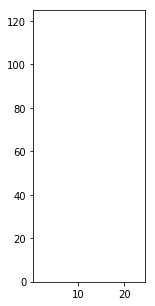

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\ma\core.py:718: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


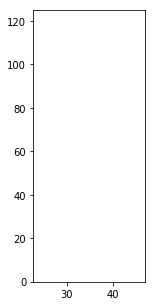

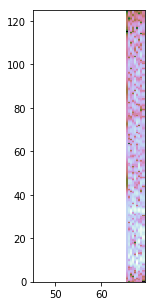

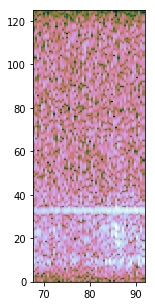

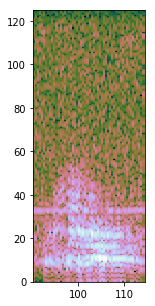

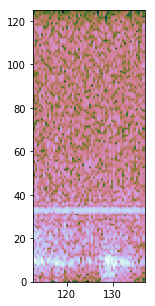

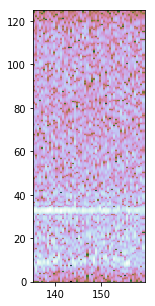

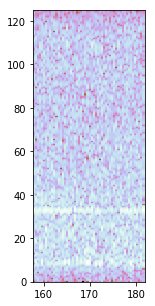

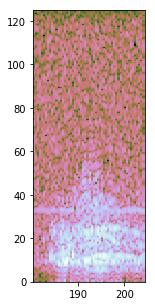

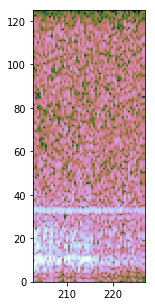

In [138]:
multi_plot(spec_slices, spec_slices_df.index.values, 0, 10)

In [19]:
spec_slices_df.drop([0.0, 22.5, 45.0], axis = 0, inplace = True)

In [20]:
spec_slices_df.head()

,0,1,2,3,4,5,6,7,8,9,...,14125,14126,14127,14128,14129,14130,14131,14132,14133,14134
0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22.5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
45.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000015,0.001056,0.010954,0.262955,0.005840,0.005709,0.027629,0.017404,0.066989,0.009624
67.5,0.816495,0.055338,0.097832,0.178955,1.057133,0.027696,0.019324,0.089897,0.331110,0.164078,...,0.027393,0.028987,0.002967,0.006771,0.002017,0.000402,0.014419,0.003373,0.004595,0.018468
90.0,1.964934,0.003048,0.138203,0.004910,0.037076,1.203305,3.331245,7.257982,4.602053,0.981703,...,0.001138,0.090593,0.038961,0.083502,0.025381,0.018275,0.001060,0.053244,0.001315,0.068907


Threshold data

In [ ]:
start = time.time()

spec_slices_thresh_df = pd.DataFrame(index = spec_slices_df.index)
for time_stamp in spec_slices_df.index:
    threshold = np.percentile(spec_slices_df.loc[time_stamp], 70)
    spec_slices_thresh_df.loc[time_stamp][spec_slices_df.loc[time_stamp] < threshold] = 0

end = time.time()
print(end - start)
spec_slices_thresh_df.head()    

Find spectral flatness of each spectrogram

In [ ]:
features_df = find_features(spec_slices_df)
print(features_df.shape)
features_df.head()

In [24]:
start = time.time()

spec_flat_df = pd.DataFrame(index = spec_slices_df.index, columns = ['time_stamp', 'spec_flat'])
for time_stamp in spec_slices_df.index:
    x = spec_slices_df.loc[time_stamp]
    spec_flat_df.loc[time_stamp]['spec_flat'] = (stats.gmean(x)) / (x.mean())
    spec_flat_df.loc[time_stamp]['time_stamp'] = time_stamp
    
print(spec_flat_df.shape)
end = time.time()
print(end - start)

spec_flat_df.head(10)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in float_scalars
  after removing the cwd from sys.path.


(32132, 2)


,time_stamp,spec_flat
0.0,0,nan
22.5,22.5,nan
45.0,45,0
67.5,67.5,0.276687
90.0,90,0.0272104
112.5,112.5,0.148359
135.0,135,0.353673
157.5,157.5,0.406697
180.0,180,0.0448962
202.5,202.5,0.162538


Threshold on spectral flatness

In [55]:
#threshold_flat = np.percentile(spec_flat_df['spec_flat'].values, 25)
#print(threshold_flat)
spec_flat_df_thresh = spec_flat_df[spec_flat_df['spec_flat'] < .1]
print(spec_flat_df_thresh.shape)
spec_flat_df_thresh.head()

(2713, 2)


,time_stamp,spec_flat
45.0,45,0
90.0,90,0.0272104
180.0,180,0.0448962
697.5,697.5,0.0923573
1957.5,1957.5,0.0368216


Create new df of thresholded slices

In [56]:
#time_stamp_list_power = power_sum_df_thresh.index.values
time_stamp_list_flatness = spec_flat_df_thresh.index.values

In [57]:
spec_slices_df_flat_thresh = spec_slices_df.loc[[time_stamp_list_flatness][0]]
print(spec_slices_df_flat_thresh.shape)
spec_slices_df_flat_thresh.head()

(2713, 14135)


,0,1,2,3,4,5,6,7,8,9,...,14125,14126,14127,14128,14129,14130,14131,14132,14133,14134
45.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000015,0.001056,0.010954,0.262955,0.005840,0.005709,0.027629,0.017404,0.066989,0.009624
90.0,1.964934,0.003048,0.138203,0.004910,0.037076,1.203305,3.331245,7.257982,4.602053,0.981703,...,0.001138,0.090593,0.038961,0.083502,0.025381,0.018275,0.001060,0.053244,0.001315,0.068907
180.0,0.005128,0.238671,0.210838,0.005532,0.127368,0.200993,0.001631,0.154877,0.718910,2.509135,...,0.002313,0.177098,0.003659,0.000069,0.000048,0.024183,0.134197,0.316331,0.014929,0.141458
697.5,0.146820,0.016642,0.012109,0.035856,0.009668,3.304869,14.701771,6.469507,0.164507,2.717068,...,0.020044,0.146236,0.082715,0.006893,0.011572,0.000509,0.000715,0.005319,0.012190,0.002799
1957.5,0.232702,0.012504,0.394030,0.272570,0.087809,0.046330,0.238250,0.080943,0.066300,0.131302,...,0.147607,0.003752,0.015435,0.011707,0.004205,0.030331,0.003841,0.004055,0.007992,0.072614


In [16]:
multi_plot(spec_slices, time_stamp_list_flatness)

NameError: name 'time_stamp_list_flatness' is not defined

Find power sum of thresholded slices

In [58]:
start = time.time()

power_sum_df = pd.DataFrame(index = spec_slices_df_flat_thresh.index, columns = ['time_stamp', 'power_sum'])
for time_stamp in spec_slices_df_flat_thresh.index:
    power_sum_df.loc[time_stamp]['power_sum'] = spec_slices_df_flat_thresh.loc[time_stamp].sum()
    power_sum_df.loc[time_stamp]['time_stamp'] = time_stamp
    
print(power_sum_df.shape)
end = time.time()
print(end - start)

power_sum_df.head()

(2713, 2)


,time_stamp,power_sum
720900.0,720900,479863
720922.5,720922,321787
720945.0,720945,540978
720967.5,720968,392765
721845.0,721845,301329


In [49]:
power_sum_df.head()

,time_stamp,power_sum
45.0,45,6116.56
90.0,90,1.36622e+06
112.5,112.5,123091
180.0,180,672823
202.5,202.5,105779


In [ ]:
plt.hist(power_sum_df['power_sum'].values)
plt.show()

In [ ]:
power_sum_df.head()

In [ ]:
power_sum_df.max()

Threshold on power sum

In [54]:
#threshold_power = np.percentile(power_sum_df['power_sum'].values, 20)
#print(threshold_power)
power_sum_df_thresh = power_sum_df[power_sum_df['power_sum'] > 200000]
print(power_sum_df_thresh.shape)
power_sum_df_thresh.head(50)

(2684, 2)


,time_stamp,power_sum
90.0,90,1.36622e+06
180.0,180,672823
292.5,292.5,200461
1957.5,1957.5,637286
2182.5,2182.5,245864
2880.0,2880,329132
3487.5,3487.5,699444
3825.0,3825,287747
3847.5,3847.5,207221
4320.0,4320,600886


In [ ]:
import math
def facet_plot(image_df, time_stamp_list_flatness):
    plt.figure(figsize = (20,20))
    plot_row_num = math.ceil(math.sqrt(len(time_stamp_list_flatness)))
    plot_col_num = math.ceil(len(time_stamp_list_flatness) / plot_row_num)
    for idx, time_stamp in enumerate(time_stamp_list_flatness):
        plt.subplot(plot_row_num, plot_col_num, idx+1)
        plt.pcolormesh((times*1000) + (time_stamp), freqs_spec / 1000, 10 * np.log10(image_df[time_stamp]))
    plt.show()

In [ ]:
facet_plot(spec_slices, time_stamp_list_flatness)

In [20]:
from sklearn.decomposition import PCA
pca = PCA(n_components=30, whiten=True)
X_transformed = pca.fit_transform(np.log(spec_slices_df))

KeyboardInterrupt: 

In [ ]:
X_transformed.shape

In [ ]:
pca.components_.shape

In [ ]:
plt.plot(pca.singular_values_)
plt.title("Singular values")

In [ ]:
pca.components_[:,:].shape

In [ ]:
pca.components_[0]

In [ ]:
# plot first ten components
plt.figure(figsize = (10,5))
u = pca.components_[:,:].reshape(30,-1,len(times))
for i in range(10):
    plt.subplot(2,5,i+1)
    # we are rescaling between 0 and 1 before plotting
    plt.imshow(u[i], cmap = 'viridis')
    plt.title('Mode '+str(i+1))

In [ ]:
plt.scatter(X_transformed[:,0], X_transformed[:,1], s=40,  marker='o', alpha=.8)
#plt.xlim(-100000,100000)
#plt.ylim(-100000,100000)
plt.title("Projection of the data on 2 components + ground truth labels")

In [ ]:
# The code below visualizes the data projected in 2D together with the original spectrograms

from matplotlib import offsetbox
from matplotlib.offsetbox import (TextArea, DrawingArea, OffsetImage,
                                  AnnotationBbox)
# Scale and visualize the embedding vectors
def plot_embedding(X, X_embedded, title=None):
    x_min, x_max = np.min(X_embedded, 0), np.max(X_embedded, 0)
    X_embedded = (X_embedded - x_min) / (x_max - x_min)

    plt.figure(figsize = (10,10))
    ax = plt.subplot(111)
    for i in range(X_embedded.shape[0]):
        plt.text(X_embedded[i, 0], X_embedded[i, 1], 'o',
                 color=plt.cm.viridis(y[i] / 0.01),
                 #color=colors[i],
                 #color=int(y[i]),
                 fontdict={'weight': 'bold', 'size': 9})

    if hasattr(offsetbox, 'AnnotationBbox'):
        # only print thumbnails with matplotlib > 1.0
        shown_images = np.array([[1., 1.]])  # just something big
        for i in range(X_embedded.shape[0]):
            dist = np.sum((X_embedded[i,:] - shown_images) ** 2, 1)
            if np.min(dist) < 4e-3:
                # don't show points that are too close
                continue
            shown_images = np.r_[shown_images, [X_embedded[i,:]]]
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(np.log(X[i,:].reshape(spec_dim)),zoom = 0.3, cmap='plasma'),
                X_embedded[i,:])
            ax.add_artist(imagebox)
    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

In [ ]:
plot_embedding(np.array(annot_slice_df), X_transformed[:,:2])

In [ ]:
# center and scale the data
scaler = StandardScaler()
slices_scaled = scaler.fit_transform(spec_slices_df)

In [ ]:
k_range = range(2,20)
scores = []
for k in k_range:
    km_ss = KMeans(n_clusters=k, random_state=1)
    km_ss.fit(slices_scaled)
    scores.append(silhouette_score(slices_scaled, km_ss.labels_))

# plot the results
plt.plot(k_range, scores)
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Coefficient')

In [ ]:
km2 = KMeans(n_clusters=3,random_state=1234)
km2.fit(slices_scaled)
score = silhouette_score(slices_scaled, km_ss.labels_)
#summary_ave['kmeans_2_scaled'] = [ "cluster_" + str(label) for label in km2.labels_ ]
#summary_ave.groupby('kmeans_2_scaled').mean()
print(score)

Create df of annotated USVs from RavenLite

In [53]:
annot_path = "C:/Users/Schindler/Documents/Schindler_Lab/Data/Analysis/Excel files/USV/USV_annot.csv"

In [54]:
data = pd.read_csv(annot_path)
annot_data = pd.DataFrame(data = data)
annot_data.head()

,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Session
0,0,18.929297,18.934698,74332.5,78276.7,0.005,3944.2,-44.4,high slug,527,cagepair
1,1,24.758961,24.769763,10012.1,13046.1,0.011,3034.0,-41.6,low slug,527,cagepair
2,2,174.353273,174.357636,34706.7,41988.2,0.004,7281.5,-41.5,bbc,527,cagepair
3,3,342.886783,342.892601,16874.1,53888.7,0.006,37014.6,-39.1,bbc,527,cagepair
4,4,393.056112,393.061930,35194.2,50970.9,0.006,15776.7,-39.1,bbc,527,cagepair


In [69]:
annot_data.groupby(['Animal', 'Session', 'Annotation']).describe()

Avg Power Density (dB FS)                        \
                                               count       mean        std   
Animal Session  Annotation                                                   
527    cagepair bbc                              5.0 -37.560000   4.500889   
                high slug                        1.0 -44.400000        NaN   
                low slug                         1.0 -41.600000        NaN   
529    cagepair bbc                              5.0 -37.360000   6.689021   
                high slug                        3.0 -52.666667   0.152753   
                low slug                         2.0 -41.400000   1.555635   
533    CPApair  high multi                       1.0 -43.200000        NaN   
                high slug                        1.0 -45.300000        NaN   
                low multi                        3.0 -38.366667   1.855622   
                low slug                         7.0 -39.700000   3.510461   
                radar                          140.0 -34.945714  10.946143   
534    CPApair  bbc                              1.0 -25.100000        NaN   
                low multi                        1.0 -40.800000        NaN   
                low slug                         9.0 -34.655556   5.207473   
535    CPApair  bbc                              1.0 -31.600000        NaN   
                high multi                       2.0 -40.100000   2.687006   
                high slug                        2.0 -46.550000   7.000357   
                low multi                        9.0 -36.555556   2.449036   
                low slug                        23.0 -41.008696   4.835937   
                radar                           16.0 -37.400000   7.596754   
540    cagepair low slug                         3.0 -43.733333   1.817507   
541    cagepair bbc                              3.0 -30.866667   2.203028   
                high multi                       2.0 -48.750000   7.283200   
                high slug                        4.0 -48.725000   3.963479   
                low multi                        1.0 -45.500000        NaN   
                low slug                         5.0 -41.320000   4.836011   
542    CPApair  bbc                              3.0 -36.633333   8.938866   
                high slug                        2.0 -37.250000   3.464823   
                low multi                        2.0 -32.950000   4.171930   
                low slug                         9.0 -40.300000   4.027406   
                radar                            1.0 -35.000000        NaN   
543    CPApair  bbc                              1.0 -30.900000        NaN   
                low multi                        1.0 -39.000000        NaN   
                low slug                         4.0 -39.575000   4.642826   
                radar                           10.0 -38.590000   5.710896   
552    cagepair bbc                              2.0 -46.400000  12.869343   
                low slug                         1.0 -40.300000        NaN   
553    cagepair high slug                        3.0 -50.433333   1.201388   
                low multi                        1.0 -43.700000        NaN   
                low slug                         4.0 -39.825000   3.386616   
554    CPApair  bbc                              4.0 -30.025000   3.413088   
                high multi                       1.0 -53.400000        NaN   
                high slug                        2.0 -46.000000   5.232590   
                low multi                        3.0 -37.433333   4.318950   
                low slug                         3.0 -38.533333   3.728717   
                radar                           49.0 -38.493878   3.886269   
555    CPApair  bbc                              2.0 -18.300000  10.465180   
                low slug                         4.0 -36.850000   4.365394   
                radar                            

Determine closest time stamp of each annotation and add as column to df

In [56]:
annot_data['Begin Time (s)_1000'] = annot_data['Begin Time (s)']*1000

In [57]:
annot_data.head()

,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Session,Begin Time (s)_1000
0,0,18.929297,18.934698,74332.5,78276.7,0.005,3944.2,-44.4,high slug,527,cagepair,18929.29701
1,1,24.758961,24.769763,10012.1,13046.1,0.011,3034.0,-41.6,low slug,527,cagepair,24758.96059
2,2,174.353273,174.357636,34706.7,41988.2,0.004,7281.5,-41.5,bbc,527,cagepair,174353.27260
3,3,342.886783,342.892601,16874.1,53888.7,0.006,37014.6,-39.1,bbc,527,cagepair,342886.78320
4,4,393.056112,393.061930,35194.2,50970.9,0.006,15776.7,-39.1,bbc,527,cagepair,393056.11160


In [58]:
annot_time_stamps = []
values = annot_data['Begin Time (s)_1000'].values
for value in values:
    time_stamp_num = int(value / 22.5)
    time_stamp_index = time_stamp_num*22.5
    annot_time_stamps.append(time_stamp_index)

annot_data['time_stamp'] = annot_time_stamps

In [59]:
annot_data.head()

,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Session,Begin Time (s)_1000,time_stamp
0,0,18.929297,18.934698,74332.5,78276.7,0.005,3944.2,-44.4,high slug,527,cagepair,18929.29701,18922.5
1,1,24.758961,24.769763,10012.1,13046.1,0.011,3034.0,-41.6,low slug,527,cagepair,24758.96059,24750.0
2,2,174.353273,174.357636,34706.7,41988.2,0.004,7281.5,-41.5,bbc,527,cagepair,174353.27260,174352.5
3,3,342.886783,342.892601,16874.1,53888.7,0.006,37014.6,-39.1,bbc,527,cagepair,342886.78320,342877.5
4,4,393.056112,393.061930,35194.2,50970.9,0.006,15776.7,-39.1,bbc,527,cagepair,393056.11160,393052.5


In [60]:
annot_535 = annot_data[(annot_data['Animal'] == 535)]
annot_535.reset_index(inplace = True)
annot_535.head()

,index,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Session,Begin Time (s)_1000,time_stamp
0,180,180,0.094071,0.119279,6944.4,25463.0,0.025,18518.6,-31.1,low multi,535,CPApair,94.070755,90.0
1,181,181,0.180763,0.218269,6558.6,25270.1,0.038,18711.5,-35.8,low multi,535,CPApair,180.763411,180.0
2,182,182,16.295757,16.295757,29128.1,29128.1,0.000,0.0,-31.6,bbc,535,CPApair,16295.756930,16290.0
3,183,183,19.109271,19.109271,27777.8,27777.8,0.000,0.0,-33.0,radar,535,CPApair,19109.271420,19102.5
4,184,184,22.832750,22.878249,4050.9,27584.9,0.045,23534.0,-37.7,low multi,535,CPApair,22832.750470,22815.0


In [61]:
annot_535_low_multi = annot_535[annot_535['Annotation'].str.contains('low multi', regex=False)]
print(annot_535_low_multi.shape)
annot_535_low_multi.head()

(9, 14)


,index,Unnamed: 0,Begin Time (s),End Time (s),Low Freq (Hz),High Freq (Hz),Delta Time (s),Delta Freq (Hz),Avg Power Density (dB FS),Annotation,Animal,Session,Begin Time (s)_1000,time_stamp
0,180,180,0.094071,0.119279,6944.4,25463.0,0.025,18518.6,-31.1,low multi,535,CPApair,94.070755,90.0
1,181,181,0.180763,0.218269,6558.6,25270.1,0.038,18711.5,-35.8,low multi,535,CPApair,180.763411,180.0
4,184,184,22.832750,22.878249,4050.9,27584.9,0.045,23534.0,-37.7,low multi,535,CPApair,22832.750470,22815.0
5,185,185,22.931125,22.977238,4629.6,28549.4,0.046,23919.8,-38.5,low multi,535,CPApair,22931.125110,22927.5
6,186,186,23.037493,23.076228,5594.1,25463.0,0.039,19868.9,-36.9,low multi,535,CPApair,23037.492700,23017.5


In [62]:
annot_535_low_multi_slices = spec_slices_df.loc[annot_535_low_multi['time_stamp']]
print(annot_535_low_multi_slices.shape)
annot_535_low_multi_slices.head()

(9, 14135)


,0,1,2,3,4,5,6,7,8,9,...,14125,14126,14127,14128,14129,14130,14131,14132,14133,14134
90.0,1.964934,0.003048,0.138203,0.004910,0.037076,1.203305,3.331245,7.257982,4.602053,0.981703,...,0.001138,0.090593,0.038961,0.083502,0.025381,0.018275,0.001060,0.053244,0.001315,0.068907
180.0,0.005128,0.238671,0.210838,0.005532,0.127368,0.200993,0.001631,0.154877,0.718910,2.509135,...,0.002313,0.177098,0.003659,0.000069,0.000048,0.024183,0.134197,0.316331,0.014929,0.141458
22815.0,0.449027,0.097122,0.361959,0.260177,0.234632,1.952602,0.164605,2.917882,0.512671,0.387702,...,0.002925,0.003967,0.033448,0.004975,0.005780,0.075890,0.060433,0.036368,0.010420,0.013364
22927.5,0.001184,0.536350,0.006682,0.034802,1.824941,0.060408,0.356312,0.534787,0.019283,0.995333,...,0.087145,0.015806,0.000723,0.160924,0.000438,0.024022,0.000104,0.061356,0.000271,0.001976
23017.5,0.002568,0.632310,0.063833,0.140785,0.003965,0.098860,0.059881,0.025096,0.090546,0.027682,...,0.019771,0.124968,0.006259,0.049969,0.030311,0.050403,0.011687,0.043325,0.016678,0.257367


In [64]:
annot_features_df_535_low_multi_slices = find_features(annot_535_low_multi_slices)
print(annot_features_df_535_low_multi_slices.shape)
annot_features_df_535_low_multi_slices

0.24289369583129883
(9, 3)


,time_stamp,spec_flat,power_sum
90.0,90,0.0272104,1.36622e+06
180.0,180,0.0448962,672823
22815.0,22815,0.0792179,247731
22927.5,22927.5,0.0602415,406942
23017.5,23017.5,0.204439,66955.5
23130.0,23130,0.0679837,347691
23242.5,23242.5,0.0904234,186790
201127.5,201128,0.02894,993063
370552.5,370552,0.121451,141000


In [66]:
print(annot_features_df_535_low_multi_slices['spec_flat'].max())
print(annot_features_df_535_low_multi_slices['spec_flat'].min())
print(annot_features_df_535_low_multi_slices['spec_flat'].mean())
print(annot_features_df_535_low_multi_slices['power_sum'].max())
print(annot_features_df_535_low_multi_slices['power_sum'].min())
print(annot_features_df_535_low_multi_slices['power_sum'].mean())

0.20443872
0.02721041
0.08053368330001831
1366219.0
66955.47
492134.94444444444


In [35]:
time_stamp_list = annot_slice_df.index.values

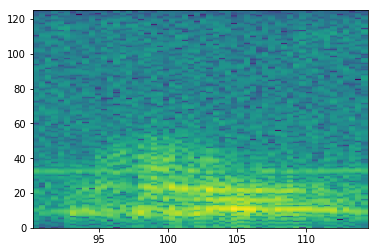

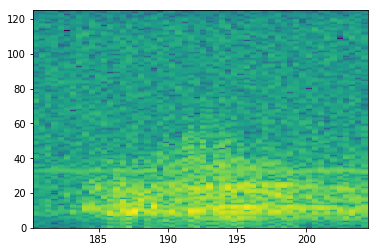

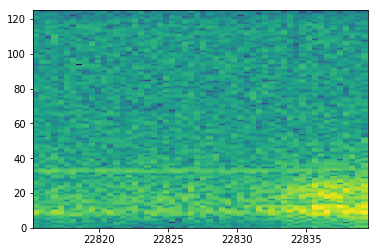

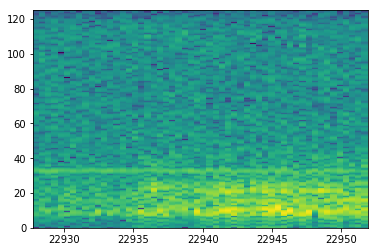

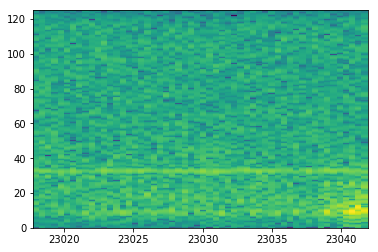

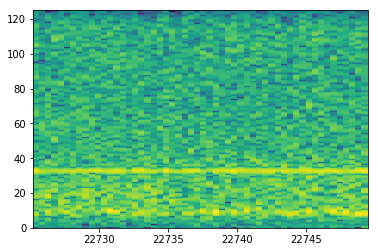

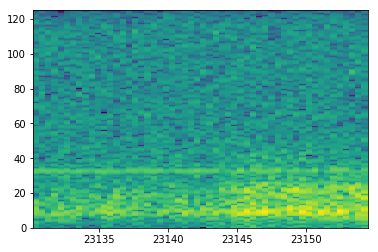

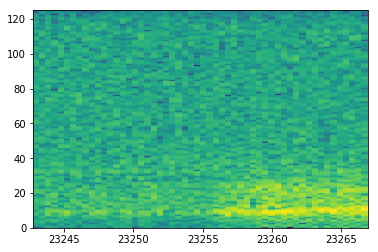

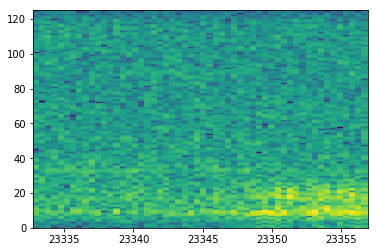

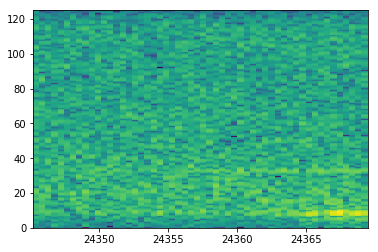

In [36]:
multi_plot(spec_slices, time_stamp_list)

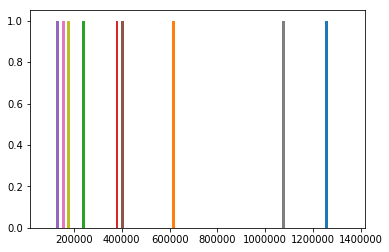

In [68]:
plt.hist(annot_features_df_535_low_multi_slices['power_sum'].values)
plt.show()